## Introduction

The Quantum Generative Adversarial Network (QGAN) [[1]](https://github.com/Qiskit/textbook/blob/main/notebooks/quantum-machine-learning/qgan.ipynb)  [[2]](https://arxiv.org/abs/1406.2661) we propose consists of two Quantum Neural Network (QNN) [[3]](https://qiskit-community.github.io/qiskit-machine-learning/tutorials/01_neural_networks.html): a generator and a discriminator. The generator is responsible for creating synthetic data samples. The discriminator evaluates the authenticity of the created samples by distinguishing between real and generated data. Through an adversarial training process, both networks continuously improve, leading to the generation of increasingly realistic data. 
This fully quantum approach benefits from the strengths of quantum state preparation and gradient calculation combined with classical optimizators [[4]](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).
The data used to train the QGAN in this implementation is a probability distributions.

This implementation uses aer_simulator_statevector.

## Implementation (statevector simulation)

In [2]:
#--- INSTALATION INSTRUCTIONS ---#

# For linux 64-bit systems,
#uname -a

# Conda quick installation
#mkdir -p ~/miniconda3
#wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O ~/miniconda3/miniconda.sh
#bash ~/miniconda3/miniconda.sh -b -u -p ~/miniconda3
#rm ~/miniconda3/miniconda.sh

# Create enviroment with conda
#conda create -n myenv python=3.10
#conda activate myenv
#pip install qiskit==1.4.5 qiskit-machine-learning==0.8.4 'qiskit-machine-learning[sparse]' torch matplotlib pylatexenc ipykernel
# IMPORTANT: Make sure you are on 3.10
# May need to restart the kernel after instalation

#--- Imports ---#
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit import qpy

import numpy as np
import torch
import matplotlib.pyplot as plt

In [24]:
#- Visualization configuration -#

# Visualization configuration dict
visual_config = {
    'train': False,
    'draw_circuits': True,
    'draw_probs': True,
    'draw_results': True,
    'circuits_file': "data/fullyq_torch/sim/q4/seed1/" + 'circuits.qpy',
    'training_data_file': "data/fullyq_torch/sim/q4/seed1/" + 'training_data.pth'
}

In [ ]:
#- Get training data -#
if visual_config['train']:
    ! python3 sim_torchc.py --n_qubits 4

In [25]:
#- Load data -#

# Load circuits
with open(visual_config['circuits_file'], 'rb') as fd:
    circuits = qpy.load(fd)
    
real_circuit = circuits[0]
generator_circuit = circuits[1]
discriminator_circuit = circuits[2]


# Load training data
params = torch.load(visual_config['training_data_file'], weights_only=False)

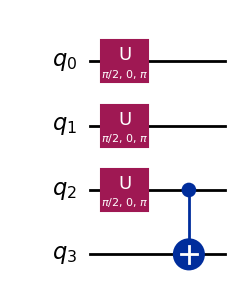

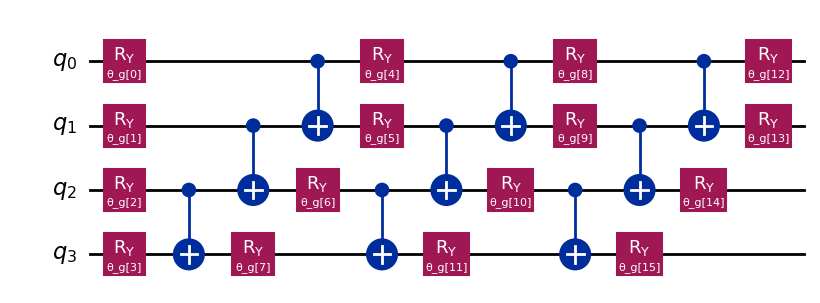

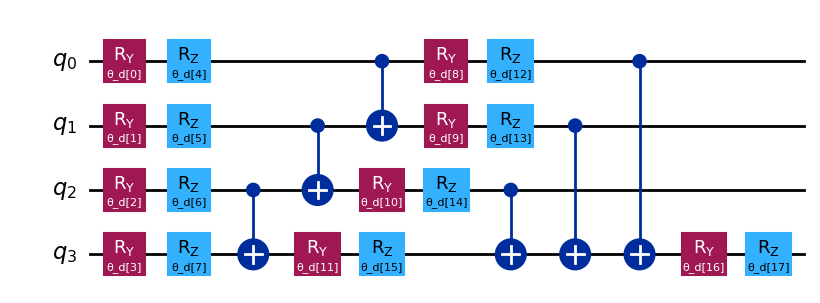

[-2.01537184  2.43186558 -2.32312606  2.10501706  0.56135267 -0.92876715
 -0.29118074 -0.63860069 -1.99929878 -2.43889769  1.00321975 -2.57090617
  0.29465156 -2.39886298 -0.99119979 -1.23089719 -2.5597945  -2.88004417]


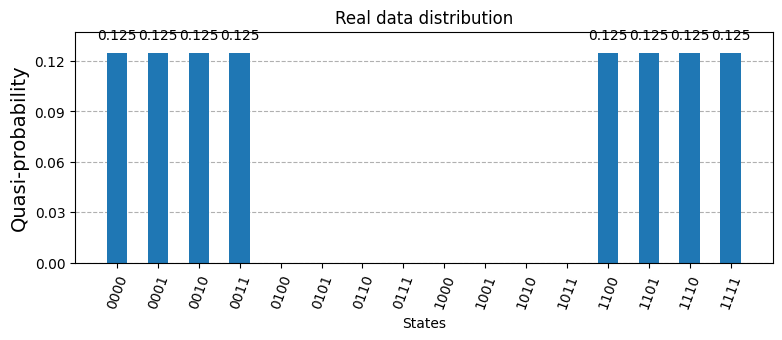

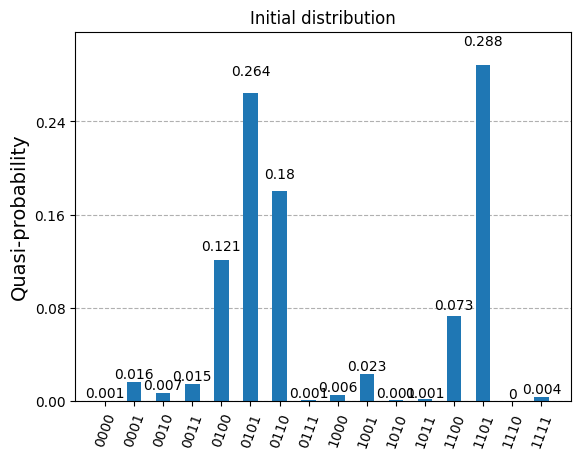

In [13]:
#- Circuits visualization -#

# Real data circuit
if visual_config['draw_circuits']:
    display(real_circuit.decompose(reps=5).draw('mpl'))

# Real data circuit probability distribution
if visual_config['draw_probs']:
    n_qubits = generator_circuit.num_qubits
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**n_qubits):
                key = format(n, 'b').zfill(n_qubits)
                if key not in dict.keys():
                    dict[key] = 0.0

    real_prob_dict = Statevector(real_circuit).probabilities_dict()
    prepare_dicts([real_prob_dict])
    fig, ax1 = plt.subplots(1, 1, figsize=(9, 3))
    ax1.set_title("Real data distribution")
    ax1.set_xlabel("States")
    ax1.set_ylabel("Probabilities")
    plot_histogram(real_prob_dict, ax=ax1)


# Generator circuit
if visual_config['draw_circuits']:
    display(generator_circuit.draw('mpl'))

# Generator initial probability distribution
if visual_config['draw_probs']:
    init_gen_circuit = generator_circuit.assign_parameters(params['init_gen_params'])
    init_prob_dict = Statevector(init_gen_circuit).probabilities_dict()
    fig, ax1 = plt.subplots(1, 1, sharey=True)
    ax1.set_title("Initial distribution")
    plot_histogram(init_prob_dict, ax=ax1)


# Discriminator circuit
if visual_config['draw_circuits']:
    display(discriminator_circuit.draw('mpl'))

# Discriminator initial parameters
print(params['init_disc_params'])

Training complete: data/fullyq_torch/sim/q4/seed1/training_data.pth 
Best KLDiv: 0.6770778201569114 in epoch 83 
Improvement: 1.123298624053907


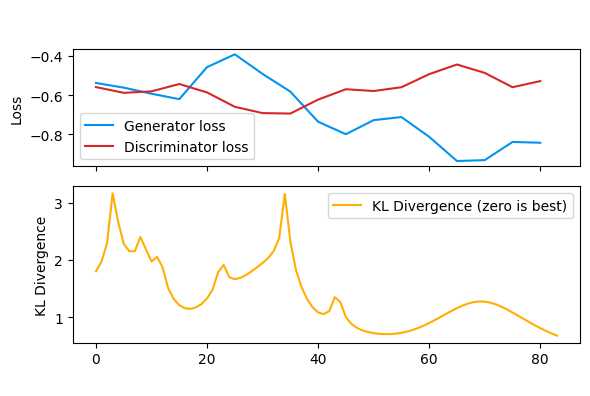

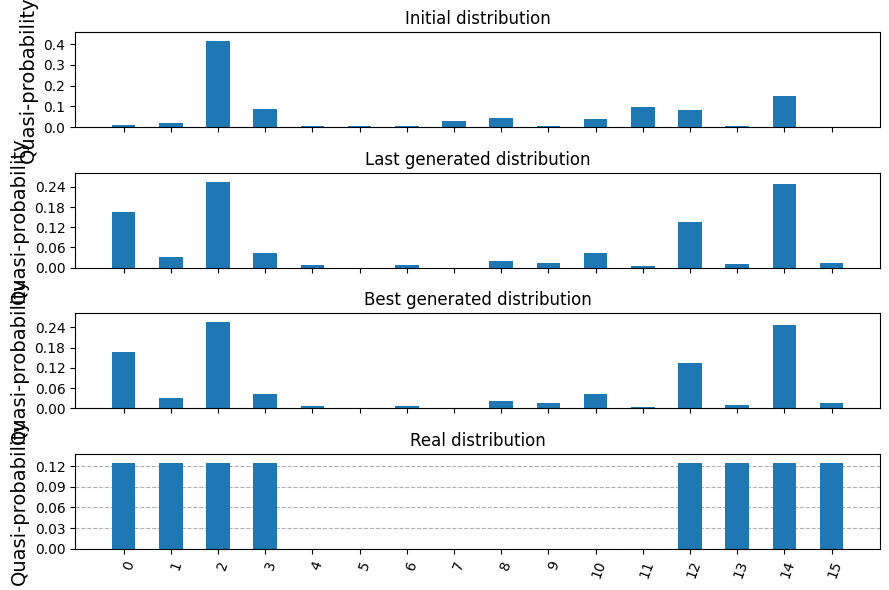

In [26]:
#- Training visualizartion -#

# Visualize training progress
if visual_config['draw_results']:
        gloss = params['metrics']['gloss']
        dloss = params['metrics']['dloss']
        kl_div = params['metrics']['kl_div']

        gloss_ax = list(gloss.keys())
        gloss_data = list(gloss.values())
        dloss_ax = list(dloss.keys())
        dloss_data = list(dloss.values())
        kl_div_ax = list(kl_div.keys())
        kl_div_data = list(kl_div.values())

        fig, (loss, kl) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [0.75, 1]}, figsize=(6,4))
        fig.suptitle('QGAN training stats', color="#ffffffff")
        kl.set_xlabel("Epochs", color="#ffffffff")
        loss.plot(gloss_ax, gloss_data, label="Generator loss", color="#0094f0ff")
        loss.plot(dloss_ax, dloss_data, label="Discriminator loss", color="C3")
        loss.legend()
        loss.set(ylabel='Loss')
        kl.plot(kl_div_ax, kl_div_data, label="KL Divergence (zero is best)", color="#ffaf01ff")
        kl.set(ylabel='KL Divergence')
        kl.legend()
        fig.tight_layout()

        print("Training complete:", visual_config['training_data_file'], "\nBest KLDiv:", np.min(kl_div_data), "in epoch", np.argmin(kl_div_data), "\nImprovement:", kl_div_data[0]-np.min(kl_div_data))



# Analyze generator circuit with new parameters
if visual_config['draw_results']:

    dict1 = Statevector(generator_circuit.assign_parameters(params['init_gen_params'])).probabilities_dict()
    dict2 = Statevector(generator_circuit.assign_parameters(params['gen_params'].detach().numpy())).probabilities_dict()
    dict3 = Statevector(generator_circuit.assign_parameters(params['best_gen_params'])).probabilities_dict()
    dict4 = Statevector(real_circuit).probabilities_dict()
    
    n_qubits = generator_circuit.num_qubits
    def prepare_dicts(dicts):
        for dict in dicts:
            for n in range(2**n_qubits):
                key = format(n, 'b').zfill(n_qubits)
                if key not in dict.keys():
                    dict[n] = 0.0
                else:
                    dict[n] = dict[key]
                    del dict[key]
        

    prepare_dicts([dict1, dict2, dict3, dict4])

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharey=False, sharex=True, figsize=(9,6))
    
    ax1.set_ylabel('Probabilities')
    ax1.set_title("Initial distribution")
    ax2.set_title("Last generated distribution")
    ax3.set_title("Best generated distribution")
    ax4.set_title("Real distribution")
    plot_histogram(dict1, ax=ax1, bar_labels=False)
    plot_histogram(dict2, ax=ax2, bar_labels=False)
    plot_histogram(dict3, ax=ax3, bar_labels=False)
    plot_histogram(dict4, ax=ax4, bar_labels=False)
    fig.tight_layout()